# 2. Run segmentation free methods

We want to perform segmentation-free methods in order to identify areas that locally resemble cell bodies and, thus, could be considered as intracellular. In this notebook we perform segmentation-free analysis with different algorithms (t.b.a)

## Import packages

In [1]:
import spatialdata as sd
import troutpy

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Read SpatialData dataset

We read the sdata cropped object we created in ``0.format_xenium_sdata.ipynb``

In [8]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/

### Run  segmentation-free (points2regions)

We use ``troutpy.tl.segmentation_free_clustering`` to perform segmentation-free clustering. Several segmentation-free algorithms are implemented within troutpy. In this case, we apply points2regions (Andersson et al. 2024) to define the main segmentation-free clusters 

In [9]:
# define points2regions_params
points2regions_params = {"num_clusters": 100, "pixel_width": 0.4, "pixel_smoothing": 3.5}
# run_segmentation_free
troutpy.tl.segmentation_free_clustering(sdata, params=points2regions_params, x="x", y="y", feature_name="feature_name", transcript_id="transcript_id")

/home/sergio/.local/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Creating anndata


/home/sergio/.local/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [20]:
sdata.points["transcripts"]["x"]

Dask Series Structure:
npartitions=1
0          float32
5132695        ...
Name: x, dtype: float32
Dask Name: getitem, 27 graph layers

The output of segmentation-free clustering is stored in ``sdata.tables['segmentation_free_table']`` as an AnnData object. In this object, every observation corresponds to an analyzed transcript, which has a Cluster assigned.

In [13]:
sdata.tables["segmentation_free_table"]

AnnData object with n_obs × n_vars = 2114819 × 13035
    obs: 'Clusters'
    uns: 'reads'
    obsm: 'spatial'

## Define extracellular transcripts

Next, we will use the output of segmentation and segmentation-free analysis to define extracellular transcripts. For this, we will employ the command ``troutpy.pp.define_extracellular``. Essentially, extracellular transcripts will be defined as those:
- Located outside segmented cells
- Assigned to segmentation-free clusters that aren't mainly located inside segmented cells (thus, enriched outside)

In [21]:
troutpy.pp.define_extracellular(sdata, method="segmentation_free", min_prop_of_extracellular=0.8)

/home/sergio/.local/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


As an output, a new column `extracellular` is created in ``sdata.points['transcripts']``. All reads considered extracellulared are assigned to True in this column. Following analysis will employ this column to divide cellular and extracellular transcripts

In [22]:
sdata.points["transcripts"]["extracellular"]

Dask Series Structure:
npartitions=1
0          bool
5132695     ...
Name: extracellular, dtype: bool
Dask Name: getitem, 31 graph layers

## Write processed output

Finally we save the processed sdata object with defined extracellular transcripts as sdata

In [7]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr). Please see the
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from /media/sergio/Discovair_final/mousebrain_prime_crop.zarr the 
         new file path: /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr                    


# Alternative segmentation free: sainsc

First we read the dataset

In [2]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/mousebrain_prime_crop_communication.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

An alternative approach is to use sainsc, which one can run using ``troutpy.pp.segmentation_free_sainsc``

In [ ]:
troutpy.pp.segmentation_free_sainsc(sdata,binsize=3,celltype_key='leiden',
                                    background_filter=0.4,gaussian_kernel_key=2.5,
                                    n_threads=16)

Next, we will use the output of segmentation and segmentation-free analysis to define extracellular transcripts. For this, we will employ the command ``troutpy.pp.define_extracellular``. Essentially, extracellular transcripts will be defined as those:
- Located outside segmented cells
- With a cosine similarity to any cellular signature lower than the x percentile_threshold of transcripts located inside the cell (defined in sainsc). Higher values will be considered cell-like transcripts

In [ ]:
troutpy.pp.define_extracellular(
    sdata,layer = "transcripts",method= "sainsc",
    unassigned_tag = "UNASSIGNED",
    copy = False, percentile_threshold = 2)

# Results visualization

In [1]:
troutpy.pl.pie(sdata, groupby="extracellular",group_key='overlaps_cell')

NameError: name 'troutpy' is not defined

<Figure size 500x500 with 0 Axes>

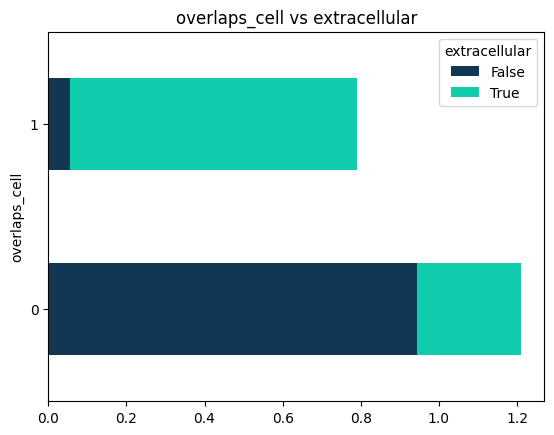

In [ ]:
troutpy.pl.crosstab(sdata,yvar='extracellular',xvar='overlaps_cell',normalize=True, cmap='troutpy',kind='barh',stacked=True)

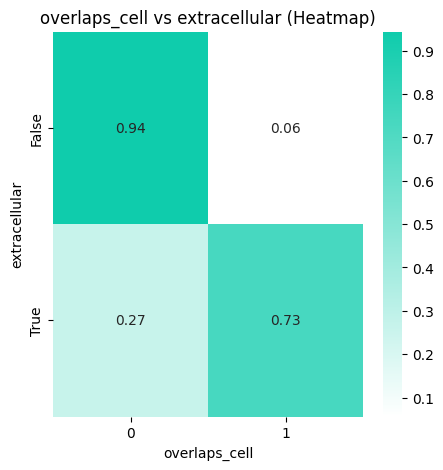

In [ ]:
troutpy.pl.crosstab(sdata,yvar='extracellular',xvar='overlaps_cell',normalize=True, cmap='Aquas',kind='heatmap',stacked=True)